In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import random
import torch
import gpytorch
from gp_mjo.gp_mjo_model import gp_mjo

from matplotlib import pyplot as plt
#from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
## Construct a dataframe from the csv dataset
colnames=['year', 'month', 'day', 'RMM1', 'RMM2','phase','amplitude','Final_value']
df = pd.read_csv('../mjo_data.csv', sep=r'[ \t]+', names=colnames, skiprows=[0])
total_days = len(df)

## Convert the columns of the dataframe to the numpy array
RMM1 = df['RMM1'].to_numpy(dtype='float64')
RMM2 = df['RMM2'].to_numpy(dtype='float64')
phase = df['phase'].to_numpy(dtype='float64')
amplitude = df['amplitude'].to_numpy(dtype='float64')
raw_datas = [RMM1,RMM2,phase,amplitude]

print(df)

       year  month  day      RMM1      RMM2  phase  amplitude  \
0      1974      6    1  1.634470  1.203040      5   2.029480   
1      1974      6    2  1.602890  1.015120      5   1.897290   
2      1974      6    3  1.516250  1.085510      5   1.864760   
3      1974      6    4  1.509810  1.035730      5   1.830920   
4      1974      6    5  1.559060  1.305180      5   2.033260   
...     ...    ...  ...       ...       ...    ...        ...   
17696  2022     11   12 -0.149320 -0.536245      2   0.556646   
17697  2022     11   13  0.292958 -0.418385      3   0.510755   
17698  2022     11   14  0.638955 -0.395651      4   0.751534   
17699  2022     11   15  0.719955 -0.220695      4   0.753022   
17700  2022     11   16  0.670323 -0.183991      4   0.695116   

                           Final_value  
0       Final_value:__OLR_&_NCEP_winds  
1       Final_value:__OLR_&_NCEP_winds  
2       Final_value:__OLR_&_NCEP_winds  
3       Final_value:__OLR_&_NCEP_winds  
4       Final_

/var/folders/51/_9h2_qzn4b54cgs0qgwxr0vh0000gn/T/ipykernel_50271/2233859504.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('../mjo_data.csv', sep=r'[ \t]+', names=colnames, skiprows=[0])


In [3]:
## Set initial values
widths = [40, 60, 80]
n_iter = 200
sigma_eps = 0.01
fixed_noise = True

n = 10000 # the number of days for training
m = 160 # the number of days for testing
c = 365 # the number of dropped buffer set

n_cv = 1 # the number of operations for cross-validation
rs = [0]*n_cv
for i in range(n_cv):
    rs[i] = random.randint(0,n) # (include 0 and n) the number of the first part of the training set
 

idx_miss = np.where(RMM1 > 1e34)[0] # index of missing value
n_miss = len(idx_miss) # the number of missing value


palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
plot_colors = palette_colors[:len(widths)]

## Set the kernel of GP
nu = 0.5 # 1.5,2.5.... smoothness parameter of Matern kernel
d = 1 # d = width or d = 1
kernel = gpytorch.kernels.MaternKernel(nu=nu, ard_num_dims=d) 

# ## Create dics with the 2 keys 'train' and 'test', divide the dataset
# data_RMM1 = {}
# data_RMM2 = {}
# data_phase = {}
# data_amplitude = {}
# data_list = [data_RMM1,data_RMM2,data_phase,data_amplitude]
# data_names = ['RMM1', 'RMM2', 'phase', 'amplitude']

# r = rs[0]
# for i, dic in enumerate(data_list):

#     # delete the missing values and their predceding values
#     raw_datas[i] = np.delete(raw_datas[i], np.arange(max(idx_miss)+1))  # np.delete(raw_datas[i], idx_miss)

#     data_tot = raw_datas[i]
#     dic['train1'] = data_tot[:r]
#     dic['test'] = data_tot[r:r+m]
#     dic['buffer'] = data_tot[r+m:r+m+c]
#     dic['train2'] = data_tot[r+m+c:n+m+c]

/Users/hchen/opt/anaconda3/envs/ml/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


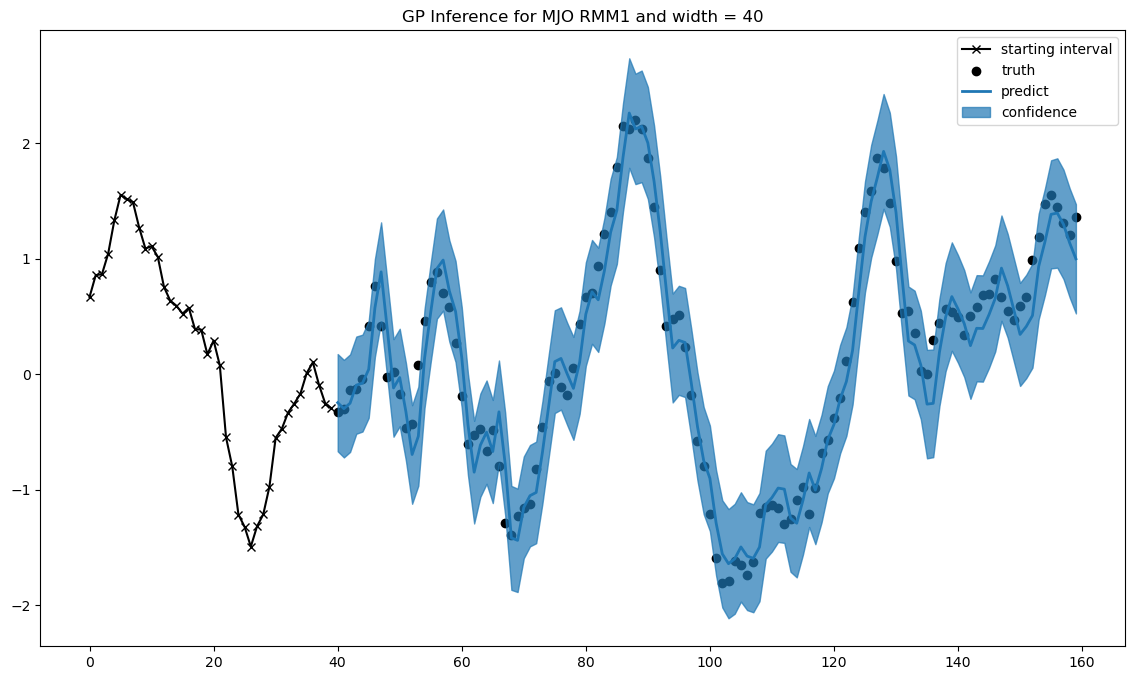

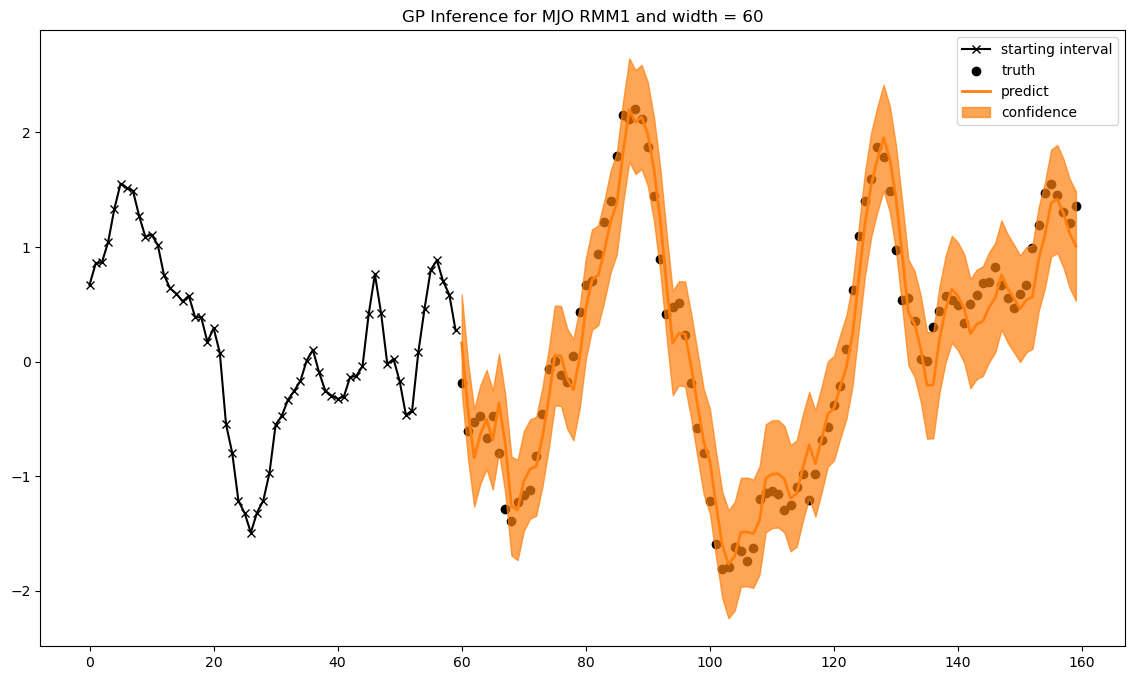

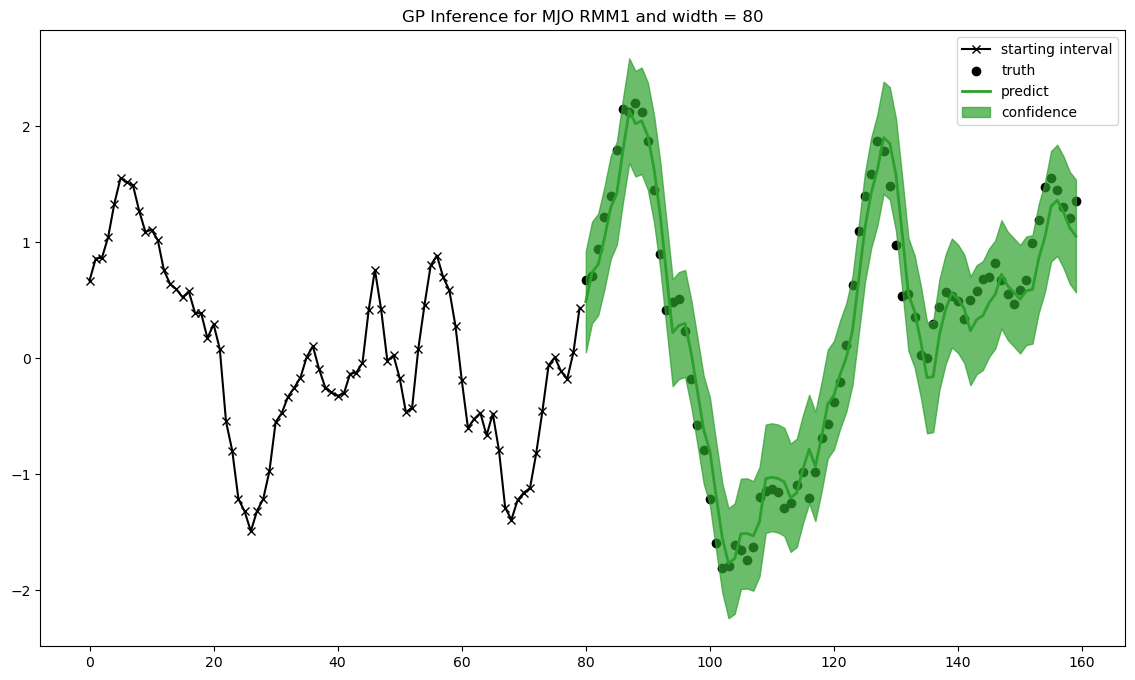

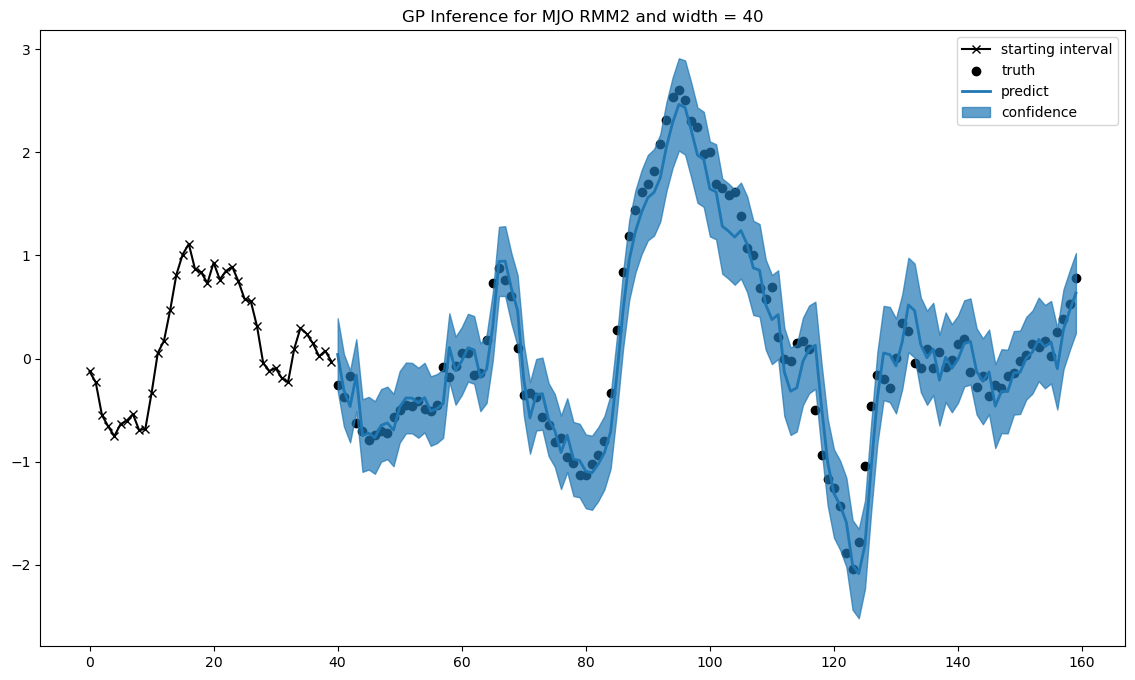

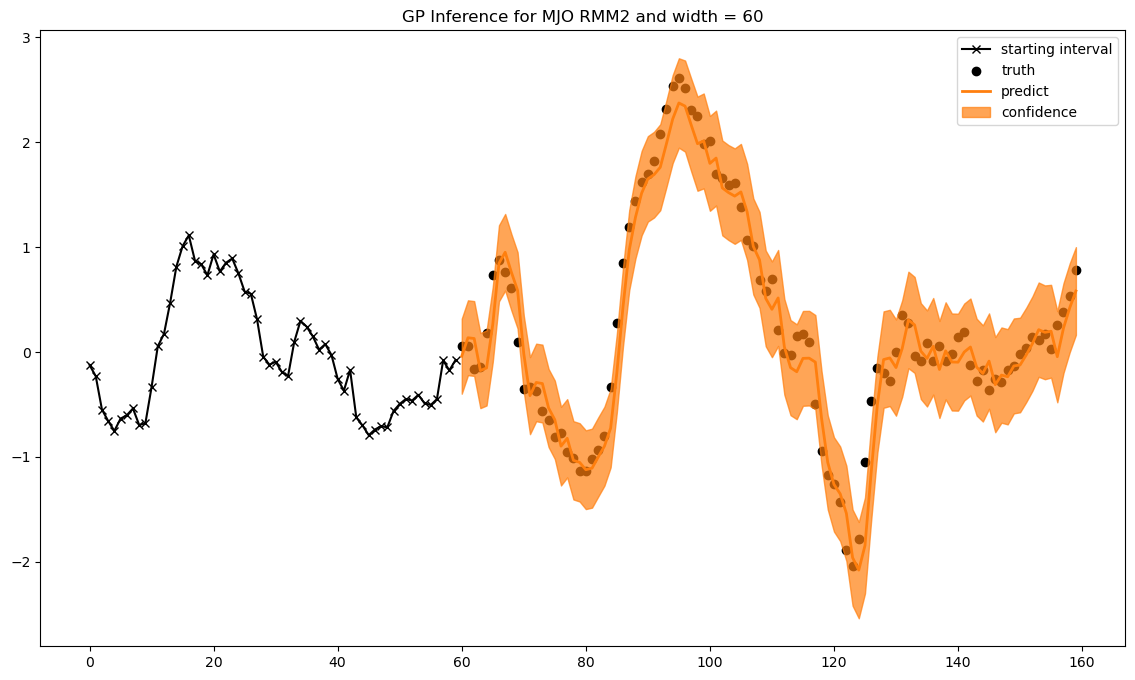

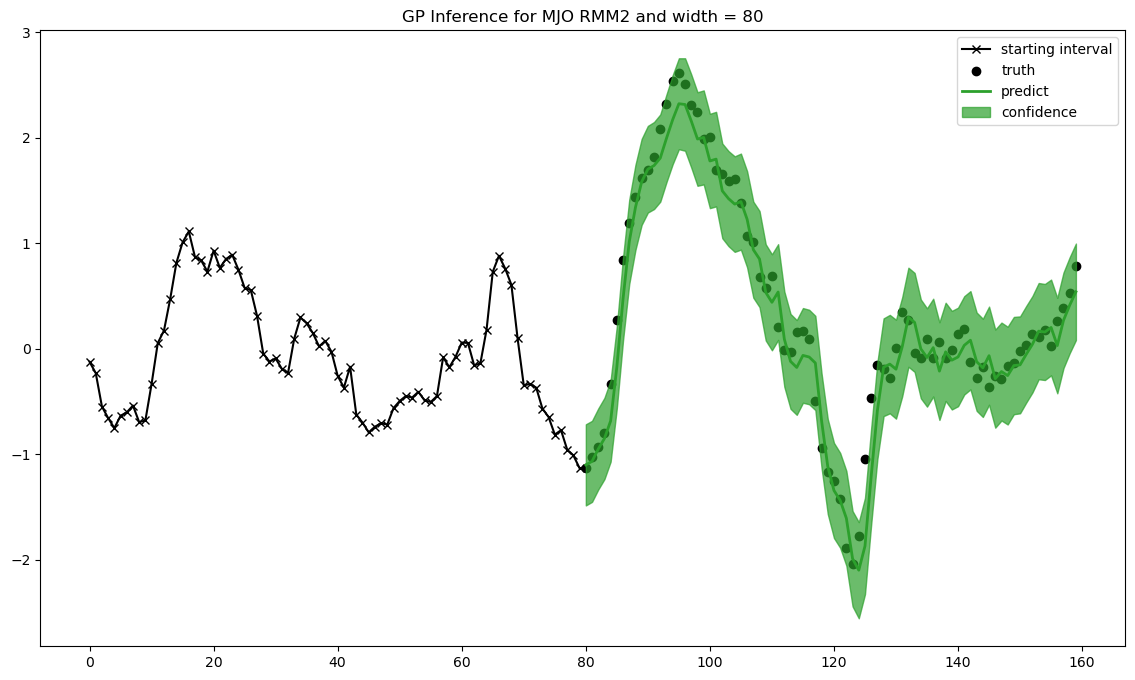

In [5]:
## Independent RMMs

# dict_preds ={}
# dict_lower_confs={}
# dict_upper_confs={}

data_names = ['RMM1', 'RMM2', 'phase', 'amplitude']

for raw_data, data_name in zip(raw_datas[:2], data_names[:2]):

    # delete the missing values and their predceding values
    data_tot = np.delete(raw_data, np.arange(max(idx_miss)+1))  # np.delete(raw_datas[i], idx_miss)
    
    for r in rs:
        dic = {}
        dic['train1'] = data_tot[:r]
        dic['test'] = data_tot[r:r+m]
        dic['buffer'] = data_tot[r+m:r+m+c]
        dic['train2'] = data_tot[r+m+c:n+m+c]
        
        for width, color in zip(widths, plot_colors):
            
            # initialize plot
            fig, ax = plt.subplots(1, 1, figsize=(14, 8))

            mjo_model = gp_mjo(dic, kernel, width, n_iter, sigma_eps,fixed_noise)
            mjo_model.train_mjo()
            mjo_model.pred_mjo()
            mjo_model.plot_mjo(ax,color)

            ax.set_title(f'GP Inference for MJO {data_name} and width = {width}')
            plt.show()

            # # store the preds, confs for different widths in the dicts
            # dict_preds[data_name][r][width] = mjo_model.observed_preds
            # dict_lower_confs[data_name][r][width] = mjo_model.lower_confs
            # dict_upper_confs[data_name][r][width] = mjo_model.upper_confs        